# 1. Set up the notebook

Import modules.

In [1]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

Define a function to load data from a hardware flight test and resample it at 100 Hz using linear interpolation.

In [2]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to solve the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [3]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

Define a function to create the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ has size $n \times n$.

In [4]:
def obsv(A, C):
    W = C
    for i in range(1, A.shape[0]):
        W = np.vstack([W, C @ np.linalg.matrix_power(A, i)])
    return W

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [5]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 2. Design observer

## 2.1 Define state-space model

Here are the matrices that describe the state-space model

$$\begin{align*} \dot{x} &= Ax + Bu \\ y &= Cx + Bu \end{align*}$$

that was derived in Lab 7 (copy/pasted from that week's analysis notebook).

In [6]:
# FIXME (copy/paste definition of A, B, C, D)
A = np.array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  9.81,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -9.81,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

B = np.array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

C = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.]])

D = np.array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## 2.2 Show that not all states are observable

Find the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ is $n \times n$.

In [7]:
W_o = obsv(A, C)

Find the rank of the observability matrix using [numpy.linalg.matrix_rank](https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html). The system is **observable** if and only if $W_o$ is **full rank**, that is, if its rank is equal to the number of states $n$.

In [8]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A.shape[0]}')

      rank of W_o is: 8
"full rank" would be: 9


If the system is *not* observable, then it is impossible to design a stable observer - that is, an observer that makes the error in your estimate of each state converge to zero over time.

In particular, the following code would produce an error if you tried to use it:
```python
# Choose weights
Q = np.eye(3) # <-- one diagonal entry for each output
R = np.eye(9) # <-- one diagonal entry for each state

# Find gain matrix
L = lqr(A.T, C.T, linalg.inv(R), linalg.inv(Q)).T
```
It does not matter what method you use - if it is impossible to design a stable observer, that's it, you're out of luck!

## 2.3 Choose a subset of states that are observable

List the index of each state to include.

In [9]:
# FIXME: delete the index of each state that is not observable!

s_obs_index = [
    0, # o_x
    1, # o_y
    2, # o_z
    #3, # psi
    4, # theta
    5, # phi
    6, # v_x
    7, # v_y
    8, # v_z
]

Define a state-space model

$$
\begin{align*}
\dot{x}_\text{obs} = A_\text{obs} x_\text{obs} + B_\text{obs} u \\
y = C_\text{obs} x_\text{obs} + D_\text{obs} u
\end{align*}
$$

with only these states.

In [10]:
A_obs = A[s_obs_index, :][:, s_obs_index]
B_obs = B[s_obs_index, :]
C_obs = C[:, s_obs_index]
D_obs = D

Show the matrices that describe this state-space model.

In [11]:
print(f'A_obs:\n{A_obs}\n')
print(f'B_obs:\n{B_obs}\n')
print(f'C_obs:\n{C_obs}\n')
print(f'D_obs:\n{D_obs}\n')

A_obs:
[[ 0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    9.81  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -9.81  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

B_obs:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

C_obs:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]

D_obs:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]



Check that this subsystem is observable:

In [12]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(obsv(A_obs, C_obs))}')
print(f'"full rank" would be: {A_obs.shape[0]}')

      rank of W_o is: 8
"full rank" would be: 8


## 2.4 Choose gain matrix for the observable subsystem

### 2.4.1 With equal weights

Choose weights $Q$ and $R$ as identity matrices.

In [13]:
# FIXME: change the size of each identity matrix to match the
# number of states and outputs for your observable subsystem

Q = np.eye(3) # <-- one diagonal entry for each output
R = np.eye(8) # <-- one diagonal entry for each state

Find gain matrix $L$ for the chosen $Q$ and $R$ by solving an LQR problem.

In [14]:
L_eq = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

Show $L$ (formatted nicely).

In [15]:
L_eq_str = np.array2string(L_eq,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L_eq = {L_eq_str}')

L_eq = [[    4.448836     0.000000     0.000000]
     [    0.000000     4.448836     0.000000]
     [    0.000000     0.000000     1.732051]
     [    1.000000     0.000000     0.000000]
     [    0.000000    -1.000000     0.000000]
     [    9.396072     0.000000     0.000000]
     [    0.000000     9.396072     0.000000]
     [    0.000000     0.000000     1.000000]]


### 2.4.2 With weights chosen by model error variance

Choose weights $Q$ and $R$ based on variance of model error.

In [16]:
# FIXME:
#
# (1) Change the size of each matrix to match the number of
#     states and outputs for your observable subsystem
#
# (2) Change the value of each diagonal entry based on your
#     results from Lab 7.

Q = np.diag([
    (1.0 / 0.071)**2,             # x_meas
    (1.0 / 0.060)**2,             # y_meas
    (1.0 / 0.090)**2,             # z_meas
])

R = np.diag([
    (1.0 / 0.070)**2, # o_x
    (1.0 / 0.064)**2, # o_y
    (1.0 / 0.027)**2, # o_z
    (1.0 / 0.056)**2, # theta
    (1.0 / 0.084)**2, # phi
    (1.0 / 0.298)**2, # v_x
    (1.0 / 0.265)**2, # v_y
    (1.0 / 0.175)**2, # v_z
])

# Q = np.diag([
#     1e-9,             # x_meas
#     1e-9,             # y_meas
#     1e-9,             # z_meas
# ])

# R = np.diag([
#     (1.0), # o_x
#     (1.0), # o_y
#     (1.0), # o_z
#     (1.0), # theta
#     (1.0), # phi
#     (1.0), # v_x
#     (1.0), # v_y
#     (1.0), # v_z
# ])

Find gain matrix $L$ for the chosen $Q$ and $R$ by solving an LQR problem.

In [17]:
L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

Show $L$ (formatted nicely).

In [18]:
L

array([[ 4.41784373,  0.        ,  0.        ],
       [ 0.        ,  5.14875128,  0.        ],
       [ 0.        ,  0.        ,  1.99471524],
       [ 0.78873239,  0.        ,  0.        ],
       [ 0.        , -1.4       ,  0.        ],
       [ 9.27265693,  0.        ,  0.        ],
       [ 0.        , 12.68593097,  0.        ],
       [ 0.        ,  0.        ,  1.94444444]])

In [19]:
L_str = np.array2string(L,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L = {L_str}')

L = [[    4.417844     0.000000     0.000000]
     [    0.000000     5.148751     0.000000]
     [    0.000000     0.000000     1.994715]
     [    0.788732     0.000000     0.000000]
     [    0.000000    -1.400000     0.000000]
     [    9.272657     0.000000     0.000000]
     [    0.000000    12.685931     0.000000]
     [    0.000000     0.000000     1.944444]]


# 3. Implement and test observer (offline)

## 3.1 Do a flight test

#### Describe the flight test

Replace this cell with the following information, at minimum:

* A description of the flight trajectory, both in words and (if you like) a snippet of code from `flight.py`.
* A description of the flight conditions (e.g., where was the flight conducted, did you power cycle the drone just before flying, were you using the positioning system or only the onboard sensors, etc.).

Also fill in the following table, which describes the point at which the drone landed, as measured with a ruler:

| | $o_x$ (meters) | $o_y$ (meters) |
| ---: | :---: | :---: |
| landing position | 1.000 | 2.000 |

## 3.2 Load and parse data from flight test

Load flight test data.

In [22]:
data = load_hardware_data(
    'hardware_data.json',   # <-- FIXME: replace with name of file with data
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=True,
)

Parse flight test data.

In [23]:
# time
t = data['time']

# states
o_x_true = data['ae483log.o_x']
o_y_true = data['ae483log.o_y']
o_z_true = data['ae483log.o_z']
psi_true = data['ae483log.psi']
theta_true = data['ae483log.theta']
phi_true = data['ae483log.phi']
v_x_true = data['ae483log.v_x']
v_y_true = data['ae483log.v_y']
v_z_true = data['ae483log.v_z']

# inputs
w_x_true = data['ae483log.w_x']
w_y_true = data['ae483log.w_y']
w_z_true = data['ae483log.w_z']
# a_z_true = data['ae483log.a_z']

# outputs
x_meas_true = data['ae483log.x_meas']
y_meas_true = data['ae483log.y_meas']
z_meas_true = data['ae483log.z_meas']

Define parameter values.

In [24]:
# Acceleration of gravity
g = 9.81

# Optical flow constant (do not change)
k_flow = 0.01 * 30.0 / np.deg2rad(4.2)

# Equilibrium value of o_z
o_z_eq = 0.5 # <-- FIXME: replace with the equilibrium height you chose in Lab 7

# Time step (should be 0.01)
dt = t[1] - t[0]
print(f'dt = {dt:.4f} (should be 0.01)')

dt = 0.0100 (should be 0.01)


## 3.3 Apply observer for gain matrix chosen by equal weights

Implement and run your observer in the following code cell. For each state, the result will be a numpy array (e.g., `o_x_hat`) that contains a state estimate at every time step.

In [25]:
# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_hat = np.zeros(len(t))
o_y_hat = np.zeros(len(t))
o_z_hat = np.zeros(len(t))
psi_hat = np.zeros(len(t))
theta_hat = np.zeros(len(t))
phi_hat = np.zeros(len(t))
v_x_hat = np.zeros(len(t))
v_y_hat = np.zeros(len(t))
v_z_hat = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_true[i]
    w_y = w_y_true[i]
    w_z = w_z_true[i]
    # a_z = a_z_true[i]
    x_meas = x_meas_true[i] - 0.06
    y_meas = y_meas_true[i] - 0.33
    z_meas = z_meas_true[i] + 0.1
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    x_meas_err = o_x - x_meas
    y_meas_err = o_y - y_meas
    z_meas_err = o_z - z_meas
    
    # Update estimates
    o_x += dt * (v_x - L_eq[0,0]*x_meas_err)   # <-- FIXME
    o_y += dt * (v_y - L_eq[1,1]*y_meas_err)   # <-- FIXME
    o_z += dt * (v_z - L_eq[2,2]*z_meas_err)   # <-- FIXME
    psi += dt * (w_z)   # <-- FIXME
    theta += dt * (w_y - L_eq[3,0]*x_meas_err) # <-- FIXME
    phi += dt * (w_x - L_eq[4,1]*y_meas_err)   # <-- FIXME
    v_x += dt * (g * theta - L_eq[5,0]*x_meas_err)   # <-- FIXME
    v_y += dt * (-g * phi - L_eq[6,1]*y_meas_err)   # <-- FIXME
    #v_z += dt * (a_z)   # <-- FIXME
    
    # Store estimates (do not change)
    o_x_hat[i] = o_x
    o_y_hat[i] = o_y
    o_z_hat[i] = o_z
    psi_hat[i] = psi
    theta_hat[i] = theta
    phi_hat[i] = phi
    v_x_hat[i] = v_x
    v_y_hat[i] = v_y
    v_z_hat[i] = v_z

Compute error in each state estimate (relative to "ground truth" from the default code).

In [26]:
o_x_err = o_x_hat - o_x_true
o_y_err = o_y_hat - o_y_true
o_z_err = o_z_hat - o_z_true
psi_err = psi_hat - psi_true
theta_err = theta_hat - theta_true
phi_err = phi_hat - phi_true
v_x_err = v_x_hat - v_x_true
v_y_err = v_y_hat - v_y_true
v_z_err = v_z_hat - v_z_true

Compare estimates with ground truth.

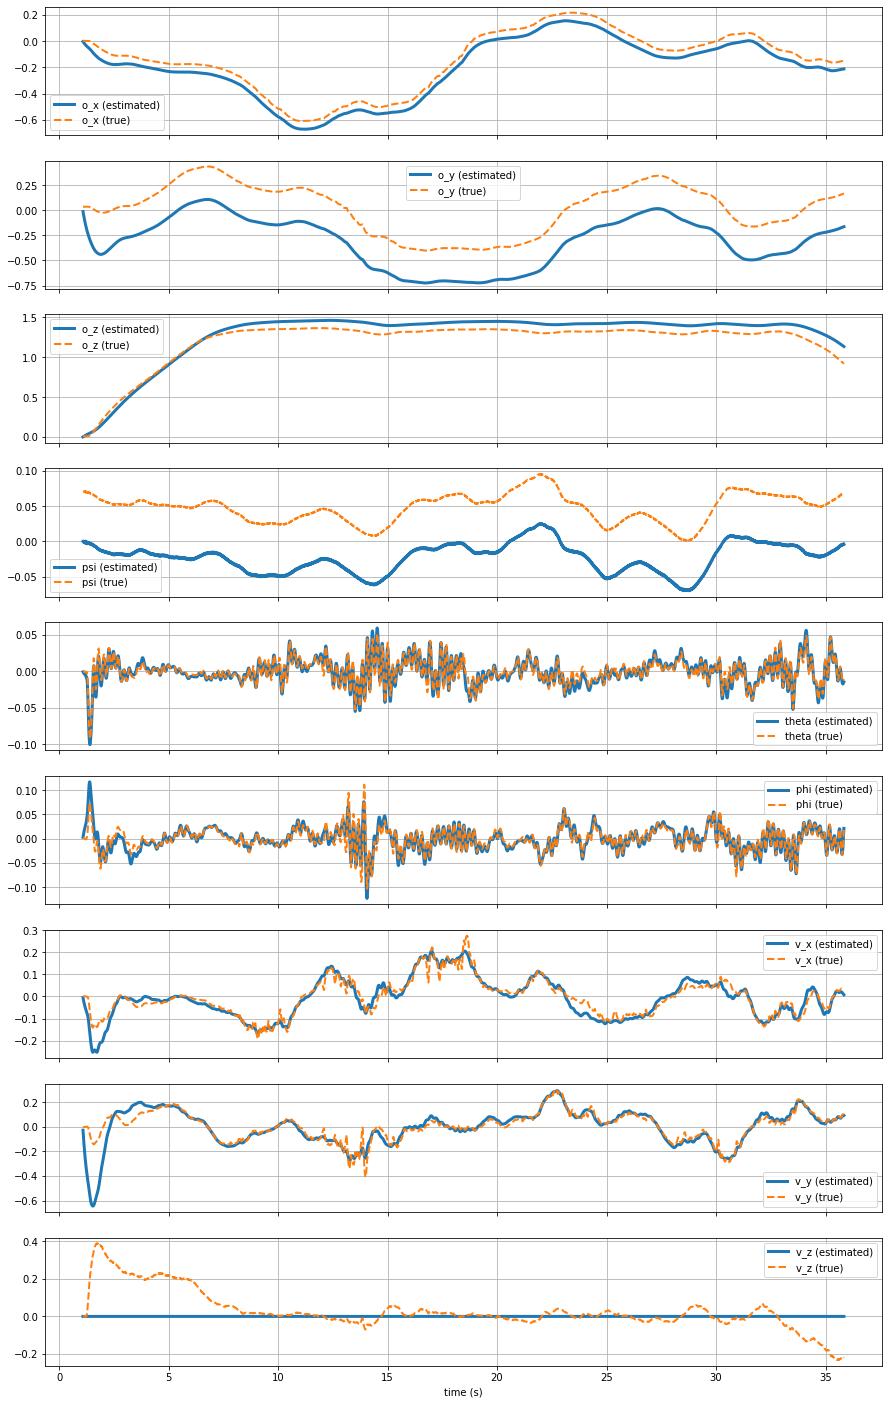

In [27]:
def comparison_plot(t, s_hat, s_true, name, ax):
    ax.plot(t, s_hat, label=f'{name} (estimated)', linewidth=3)
    ax.plot(t, s_true, '--', label=f'{name} (true)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
comparison_plot(t, o_x_hat, o_x_true, 'o_x', ax_o_x)
comparison_plot(t, o_y_hat, o_y_true, 'o_y', ax_o_y)
comparison_plot(t, o_z_hat, o_z_true, 'o_z', ax_o_z)
comparison_plot(t, psi_hat, psi_true, 'psi', ax_psi)
comparison_plot(t, theta_hat, theta_true, 'theta', ax_theta)
comparison_plot(t, phi_hat, phi_true, 'phi', ax_phi)
comparison_plot(t, v_x_hat, v_x_true, 'v_x', ax_v_x)
comparison_plot(t, v_y_hat, v_y_true, 'v_y', ax_v_y)
comparison_plot(t, v_z_hat, v_z_true, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

Plot error in each state estimate with respect to ground truth.

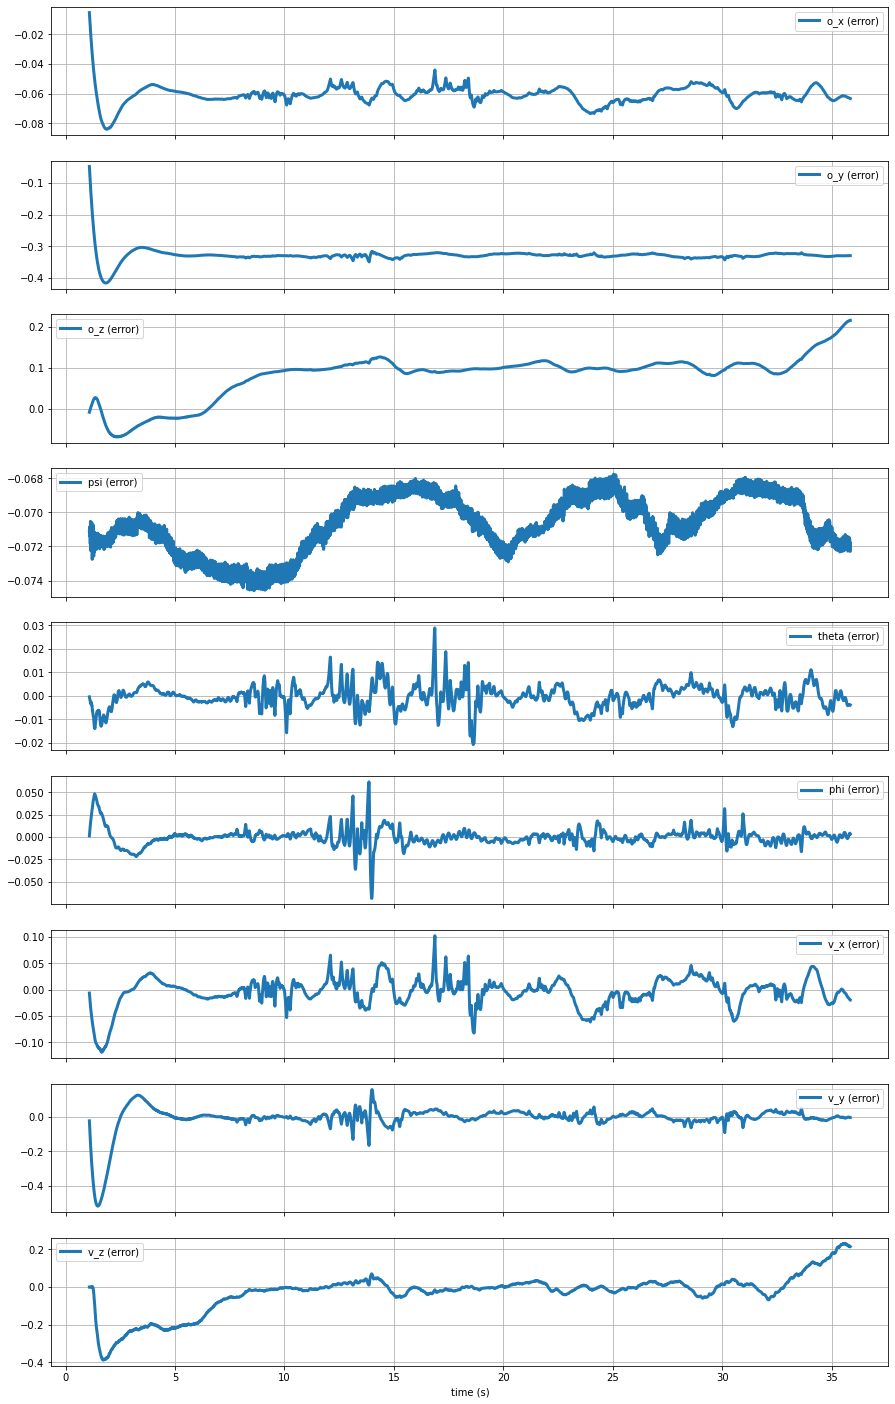

In [28]:
def error_plot(t, s_err, name, ax):
    ax.plot(t, s_err, label=f'{name} (error)', linewidth=3)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
error_plot(t, o_x_err, 'o_x', ax_o_x)
error_plot(t, o_y_err, 'o_y', ax_o_y)
error_plot(t, o_z_err, 'o_z', ax_o_z)
error_plot(t, psi_err, 'psi', ax_psi)
error_plot(t, theta_err, 'theta', ax_theta)
error_plot(t, phi_err, 'phi', ax_phi)
error_plot(t, v_x_err, 'v_x', ax_v_x)
error_plot(t, v_y_err, 'v_y', ax_v_y)
error_plot(t, v_z_err, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

Plot histogram of errors in each state estimate.

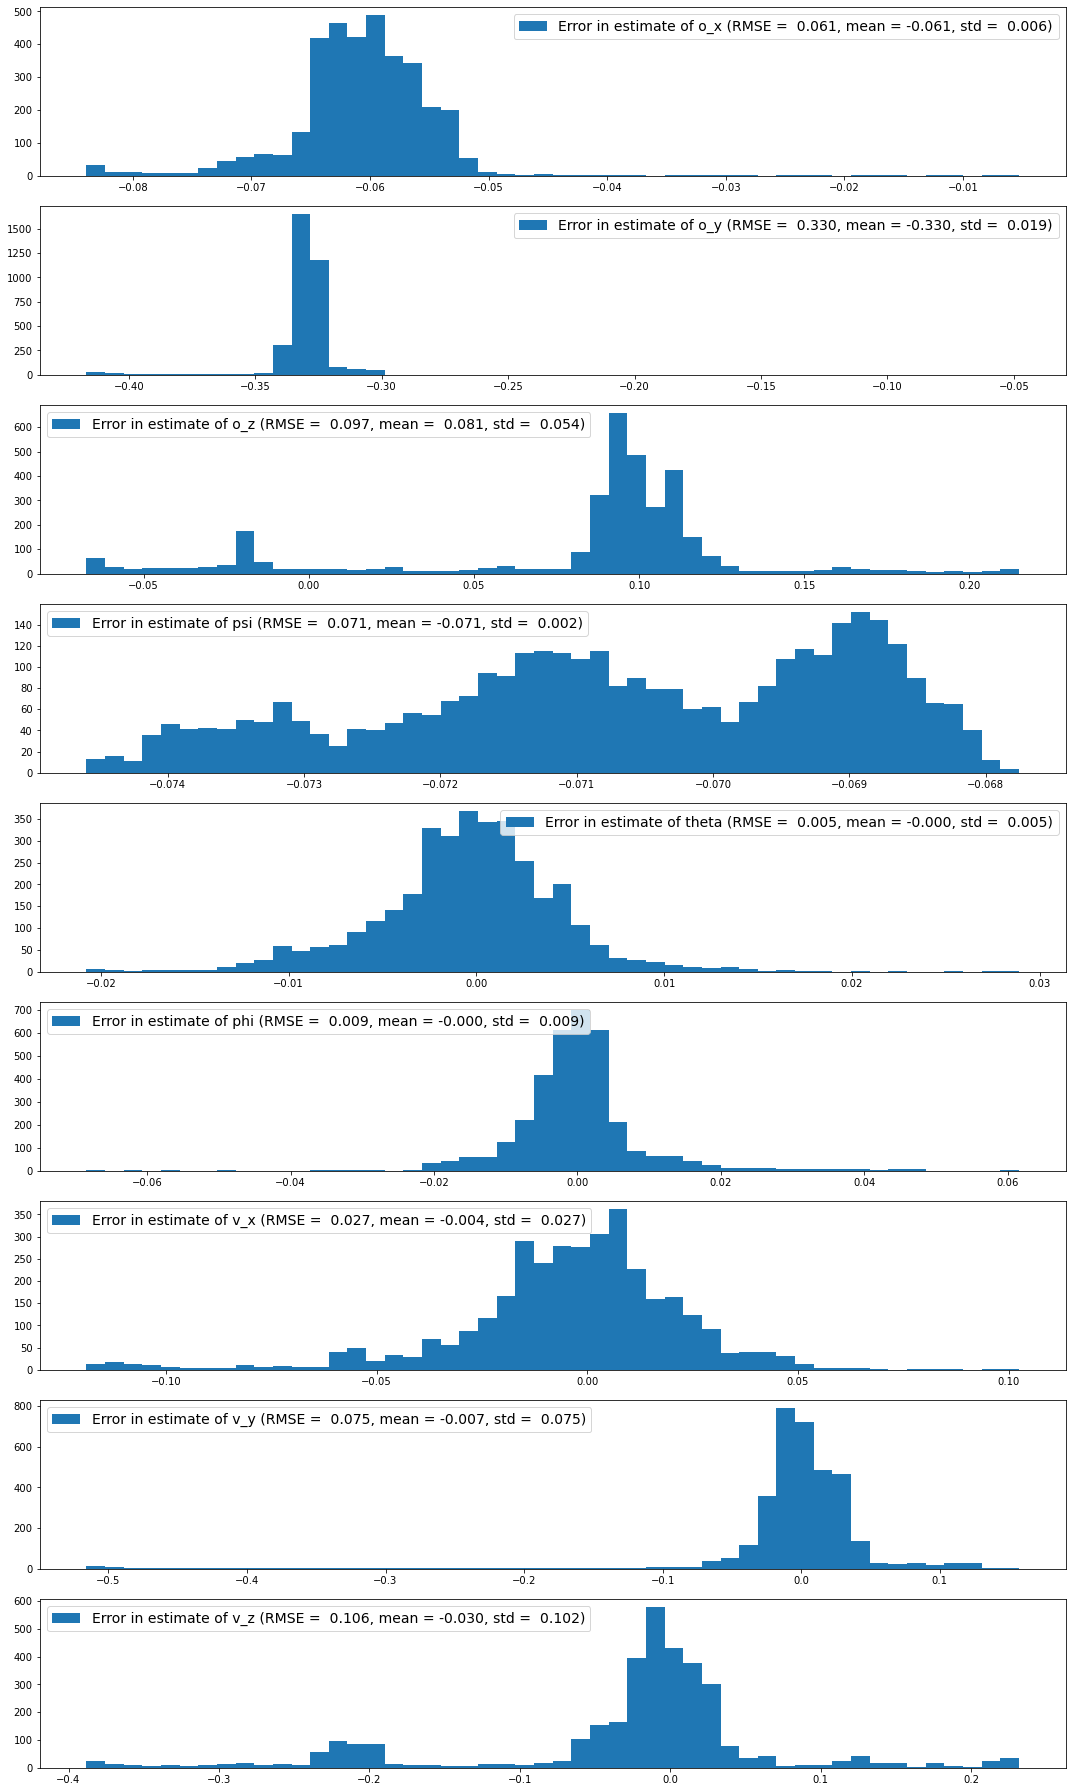

In [29]:
def histogram_plot(t, s_err, name, ax):
    label = f'Error in estimate of {name} ' + \
            f'(RMSE = {np.sqrt(np.mean(s_err**2)):6.3f}, ' + \
            f'mean = {np.mean(s_err):6.3f}, ' + \
            f'std = {np.std(s_err):6.3f})'
    ax.hist(s_err, 50, label=label)
    ax.legend(fontsize=14)

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25))
histogram_plot(t, o_x_err, 'o_x', ax_o_x)
histogram_plot(t, o_y_err, 'o_y', ax_o_y)
histogram_plot(t, o_z_err, 'o_z', ax_o_z)
histogram_plot(t, psi_err, 'psi', ax_psi)
histogram_plot(t, theta_err, 'theta', ax_theta)
histogram_plot(t, phi_err, 'phi', ax_phi)
histogram_plot(t, v_x_err, 'v_x', ax_v_x)
histogram_plot(t, v_y_err, 'v_y', ax_v_y)
histogram_plot(t, v_z_err, 'v_z', ax_v_z)
fig.tight_layout()
plt.show()

## 3.4 Apply observer for gain matrix chosen by weights from model error variance

Implement and run your observer in the following code cell. For each state, the result will be a numpy array (e.g., `o_x_hat`) that contains a state estimate at every time step.

In [30]:
# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_hat = np.zeros(len(t))
o_y_hat = np.zeros(len(t))
o_z_hat = np.zeros(len(t))
psi_hat = np.zeros(len(t))
theta_hat = np.zeros(len(t))
phi_hat = np.zeros(len(t))
v_x_hat = np.zeros(len(t))
v_y_hat = np.zeros(len(t))
v_z_hat = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_true[i]
    w_y = w_y_true[i]
    w_z = w_z_true[i]
    # a_z = a_z_true[i]
    x_meas = x_meas_true[i] - 0.06
    y_meas = y_meas_true[i] - 0.33
    z_meas = z_meas_true[i] + 0.12
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    x_meas_err = o_x - x_meas
    y_meas_err = o_y - y_meas
    z_meas_err = o_z - z_meas
    
    # Update estimates
    o_x += dt * (v_x - L[0,0]*x_meas_err)   # <-- FIXME
    o_y += dt * (v_y - L[1,1]*y_meas_err)   # <-- FIXME
    o_z += dt * (v_z - L[2,2]*z_meas_err)   # <-- FIXME
    psi += dt * (w_z)   # <-- FIXME
    theta += dt * (w_y - L[3,0]*x_meas_err) # <-- FIXME
    phi += dt * (w_x - L[4,1]*y_meas_err)   # <-- FIXME
    v_x += dt * (g * theta - L[5,0]*x_meas_err)   # <-- FIXME
    v_y += dt * (-g * phi - L[6,1]*y_meas_err)   # <-- FIXME
    #v_z += dt * (a_z)   # <-- FIXME
    
    # Store estimates (do not change)
    o_x_hat[i] = o_x
    o_y_hat[i] = o_y
    o_z_hat[i] = o_z
    psi_hat[i] = psi
    theta_hat[i] = theta
    phi_hat[i] = phi
    v_x_hat[i] = v_x
    v_y_hat[i] = v_y
    v_z_hat[i] = v_z

Compute error in each state estimate (relative to "ground truth" from the default code).

In [31]:
o_x_err = o_x_hat - o_x_true
o_y_err = o_y_hat - o_y_true
o_z_err = o_z_hat - o_z_true
psi_err = psi_hat - psi_true
theta_err = theta_hat - theta_true
phi_err = phi_hat - phi_true
v_x_err = v_x_hat - v_x_true
v_y_err = v_y_hat - v_y_true
v_z_err = v_z_hat - v_z_true

Compare estimates with ground truth.

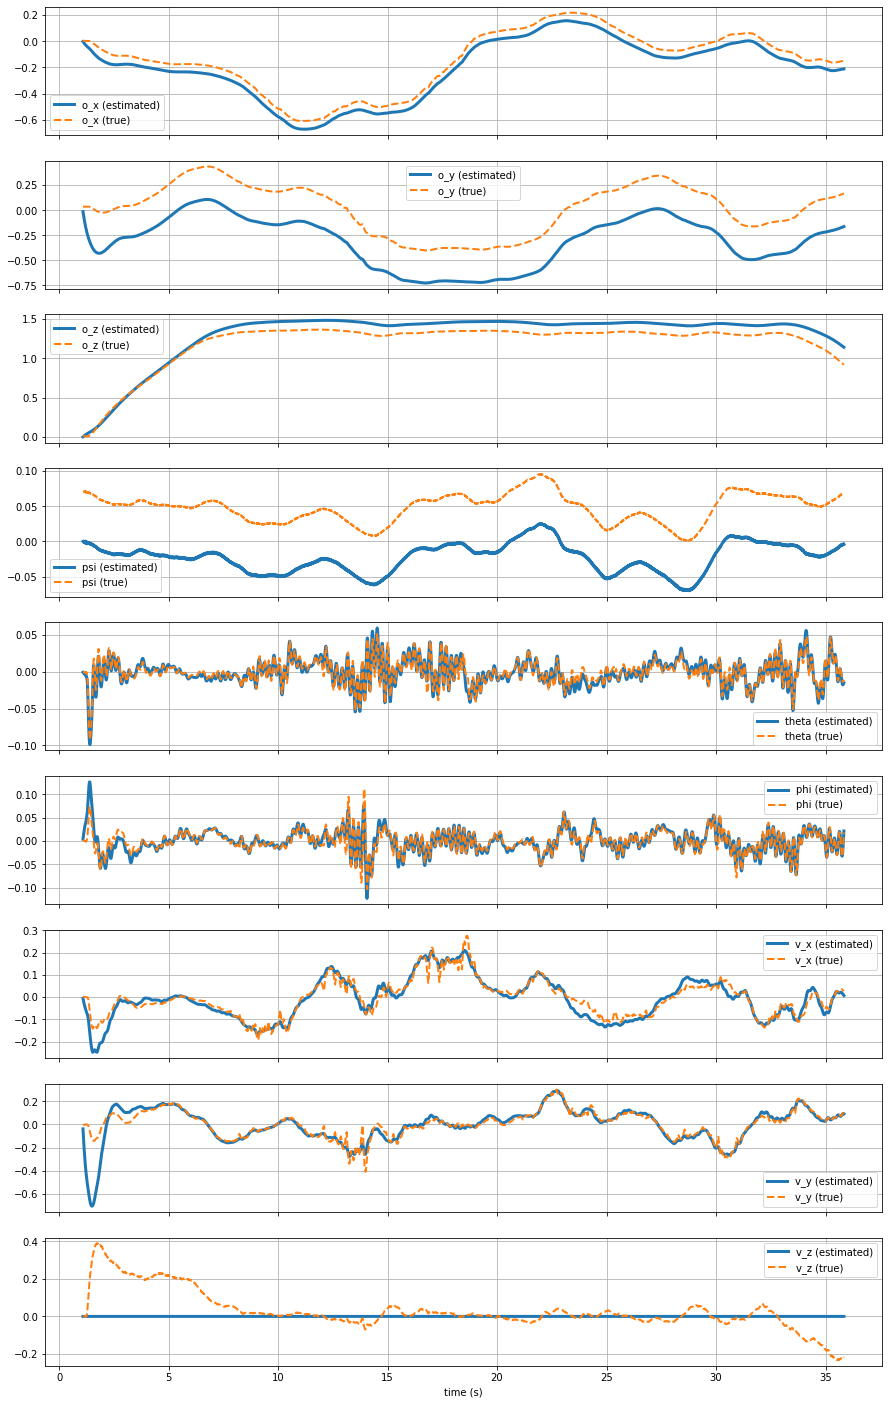

In [32]:
def comparison_plot(t, s_hat, s_true, name, ax):
    ax.plot(t, s_hat, label=f'{name} (estimated)', linewidth=3)
    ax.plot(t, s_true, '--', label=f'{name} (true)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
comparison_plot(t, o_x_hat, o_x_true, 'o_x', ax_o_x)
comparison_plot(t, o_y_hat, o_y_true, 'o_y', ax_o_y)
comparison_plot(t, o_z_hat, o_z_true, 'o_z', ax_o_z)
comparison_plot(t, psi_hat, psi_true, 'psi', ax_psi)
comparison_plot(t, theta_hat, theta_true, 'theta', ax_theta)
comparison_plot(t, phi_hat, phi_true, 'phi', ax_phi)
comparison_plot(t, v_x_hat, v_x_true, 'v_x', ax_v_x)
comparison_plot(t, v_y_hat, v_y_true, 'v_y', ax_v_y)
comparison_plot(t, v_z_hat, v_z_true, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

Plot error in each state estimate with respect to ground truth.

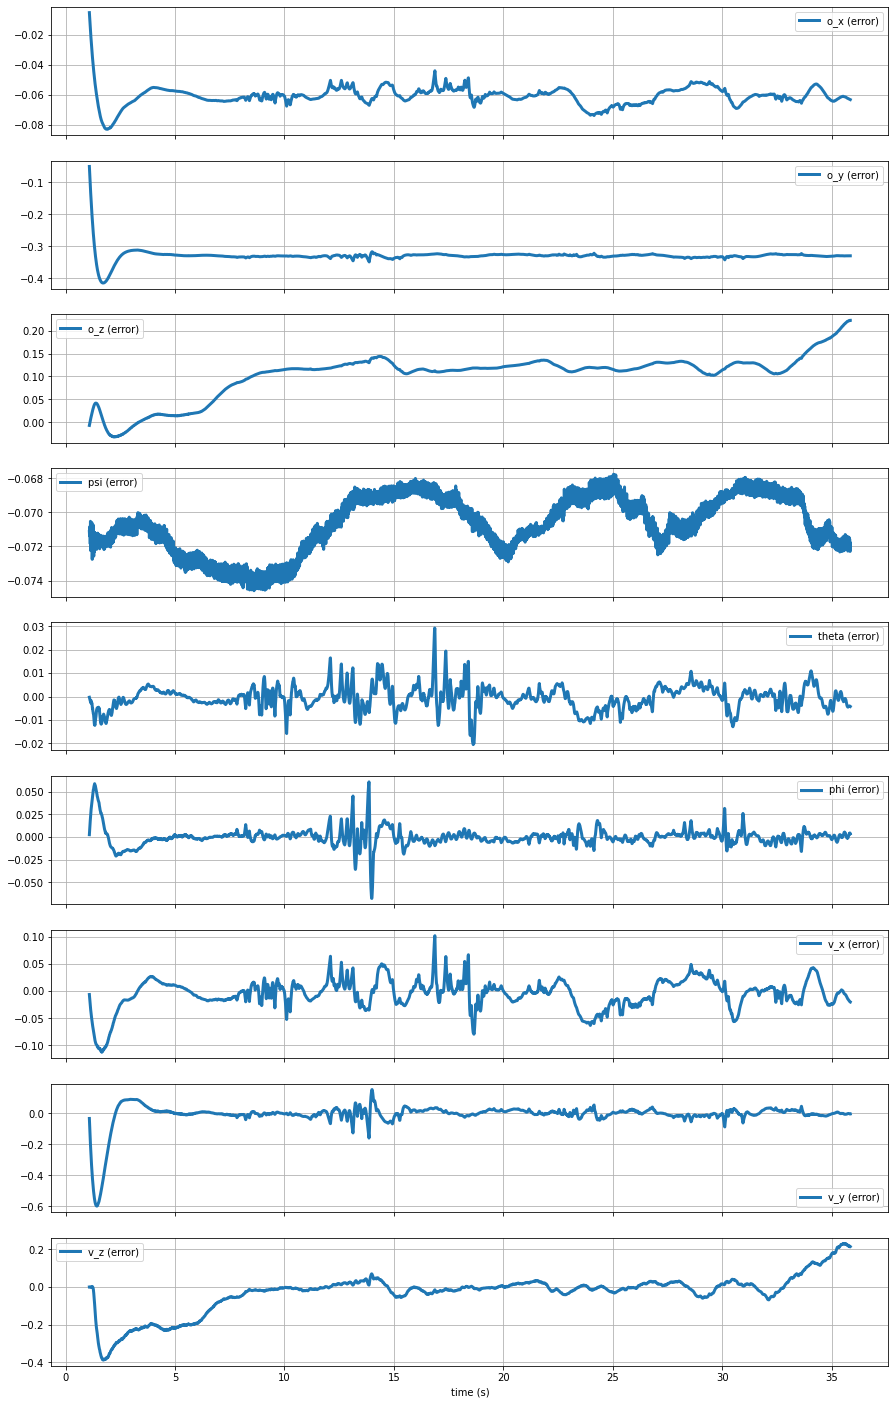

In [33]:
def error_plot(t, s_err, name, ax):
    ax.plot(t, s_err, label=f'{name} (error)', linewidth=3)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
error_plot(t, o_x_err, 'o_x', ax_o_x)
error_plot(t, o_y_err, 'o_y', ax_o_y)
error_plot(t, o_z_err, 'o_z', ax_o_z)
error_plot(t, psi_err, 'psi', ax_psi)
error_plot(t, theta_err, 'theta', ax_theta)
error_plot(t, phi_err, 'phi', ax_phi)
error_plot(t, v_x_err, 'v_x', ax_v_x)
error_plot(t, v_y_err, 'v_y', ax_v_y)
error_plot(t, v_z_err, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

Plot histogram of errors in each state estimate.

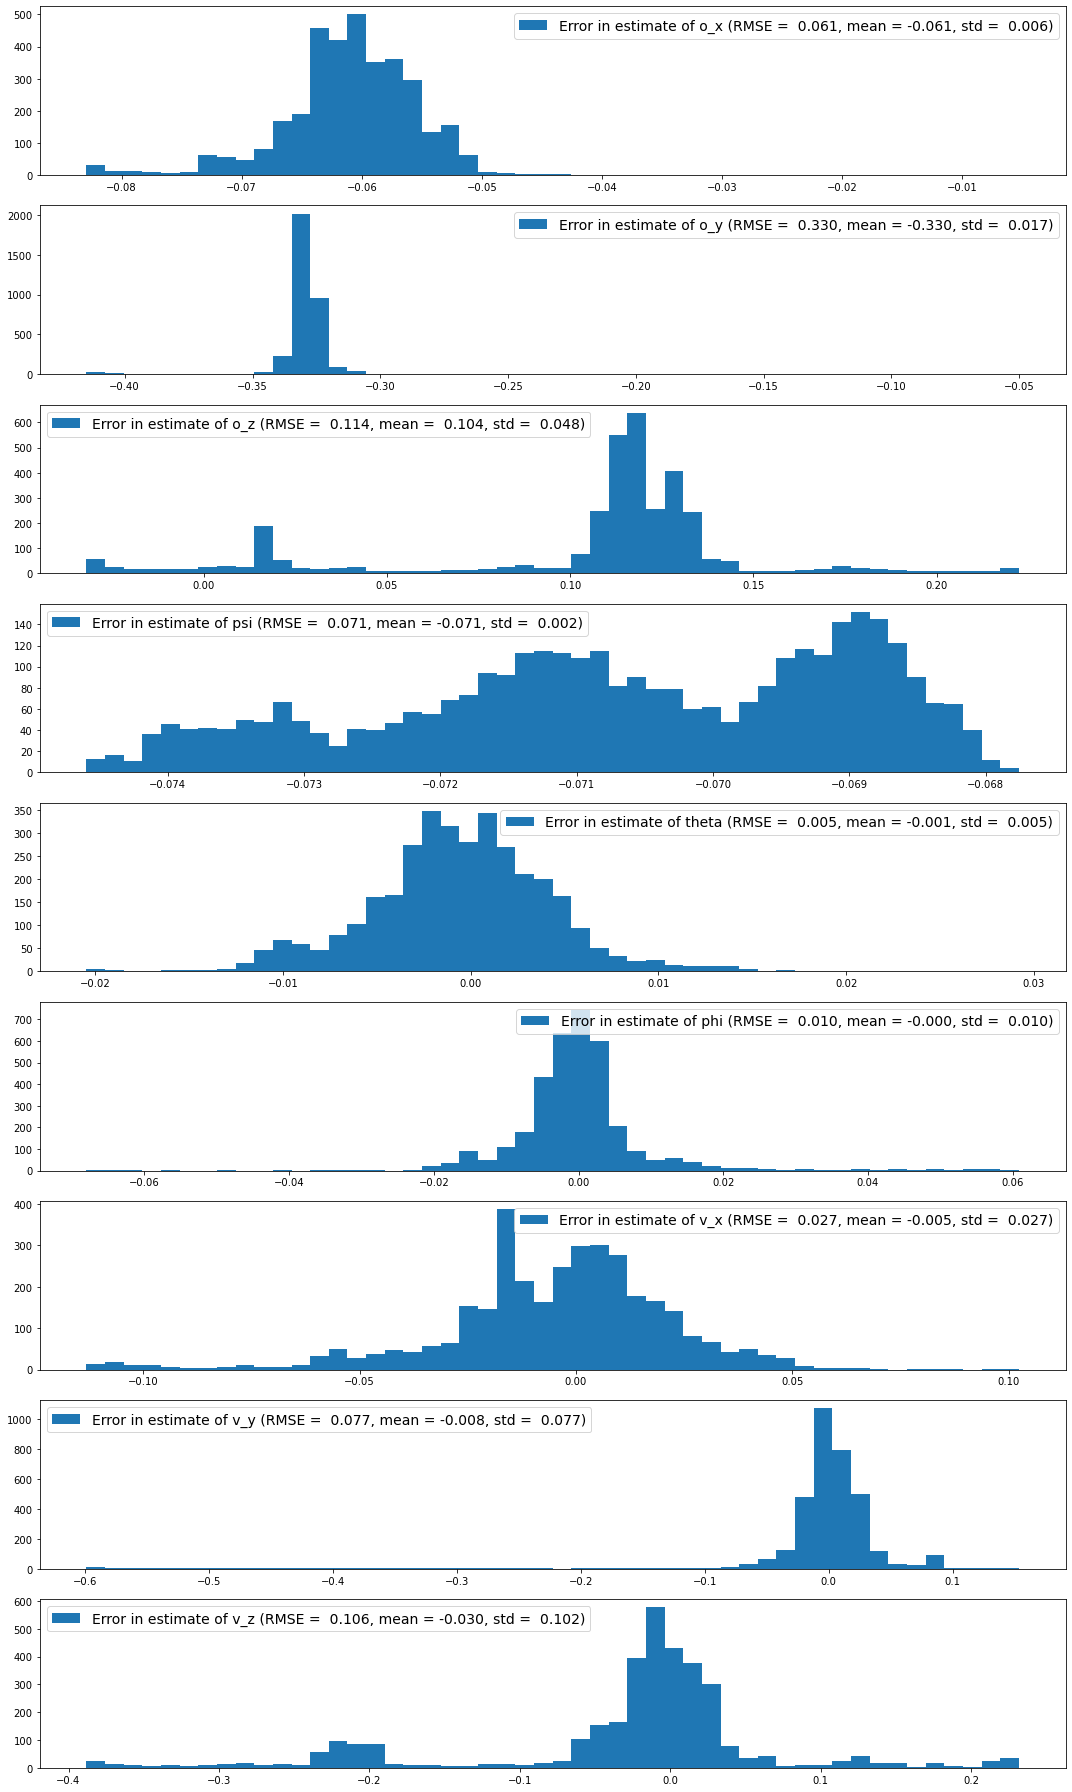

In [34]:
def histogram_plot(t, s_err, name, ax):
    label = f'Error in estimate of {name} ' + \
            f'(RMSE = {np.sqrt(np.mean(s_err**2)):6.3f}, ' + \
            f'mean = {np.mean(s_err):6.3f}, ' + \
            f'std = {np.std(s_err):6.3f})'
    ax.hist(s_err, 50, label=label)
    ax.legend(fontsize=14)

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25))
histogram_plot(t, o_x_err, 'o_x', ax_o_x)
histogram_plot(t, o_y_err, 'o_y', ax_o_y)
histogram_plot(t, o_z_err, 'o_z', ax_o_z)
histogram_plot(t, psi_err, 'psi', ax_psi)
histogram_plot(t, theta_err, 'theta', ax_theta)
histogram_plot(t, phi_err, 'phi', ax_phi)
histogram_plot(t, v_x_err, 'v_x', ax_v_x)
histogram_plot(t, v_y_err, 'v_y', ax_v_y)
histogram_plot(t, v_z_err, 'v_z', ax_v_z)
fig.tight_layout()
plt.show()

## 3.5 Summary and discussion

The following table reports the RMSE in each state estimate:

|  | $o_x$ | $o_y$ | $o_z$ | $\psi$ | $\theta$ | $\phi$ | $v_x$ | $v_y$ | $v_z$ |
| --: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| RMSE with equal weights | 0.001 | 0.002 | 0.003 | 0.004 | 0.005 | 0.006 | 0.007 | 0.008 | 0.009 |
| RMSE with weights from error model variance | 0.001 | 0.002 | 0.003 | 0.004 | 0.005 | 0.006 | 0.007 | 0.008 | 0.009 |

**Modify the text in this cell** to answer the following questions:

* Which observer performs better, the one derived from equal weights or the one derive from weights based on error model variance? Why? (Make reference to your table of results when answering this question.)
* Is there a difference in what happens to the error in your estimate of (1) observable states and (2) non-observable states over time? Why? (Make reference to your plots when answering this question.)
* We refer to the state estimates that are computed on-board by the default code as "true"? Are they? For example, compare the landing position that you measured with a ruler (Section 3.1) to the final position that was estimated by the default code - to what extent are they the same? (You may want to disinguish between observable and non-observable states when answering this question.)